# Classification Time Series Agriculture using Brazil Data Cube - CBERS 4

Authors:

Michel Chaves ([ORCID](https://https://orcid.org/0000-0002-1498-6830)), Anderson Soares ([ORCID](https://https://orcid.org/0000-0001-6513-2192)), José Fronza ([ORCID](https://orcid.org/0000-0002-0830-8101)), and Ieda Sanches ([ORCID](https://https://orcid.org/0000-0003-1296-0933)).

The development of this processing chain was supported by the São Paulo Research Foundation (FAPESP) (grant 2021/07382-2 - MC) and the National Council for Scientific and Technological Development (CNPq) (grant PQ-310042/2021-6 - IS).

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by.png" width=100px>


# 1 Setup - installing essential packages.


**PySTAC:** a library for working with SpatioTemporal Asset Catalogs (STAC) in Python 3. Some nice features of PySTAC are:

- Reading and writing STAC version 1.0. Future versions will read older versions of STAC, but always write the latest supported version. See STAC Spec Version Support for details.

- In-memory manipulations of STAC catalogs.

- Extend the I/O of STAC metadata to provide support for other platforms (e.g. cloud providers).

- Easy, efficient crawling of STAC catalogs. STAC objects are only read in when needed.

- Easily write “absolute published”, “relative published” and “self-contained” catalogs as described in the best practices documentation.

In [ ]:
!pip install pystac-client==0.3.2

**Surface Reflectance to Vegetation Indexes (sr2vgi)**. This python package is a repository for a large number of spectral indices, organized by their characteristics.

In [ ]:
!pip install git+https://github.com/brazil-data-cube/sr2vgi.git

**Rasterio:** access to geospatial raster data. Geographic information systems use GeoTIFF and other formats to organize and store gridded raster datasets such as satellite imagery and terrain models. Rasterio reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

**Shapely:** a Python package for manipulation and analysis of planar geometric objects. It is using the widely deployed open-source geometry library GEOS (the engine of PostGIS, and a port of JTS). Shapely wraps GEOS geometries and operations to provide both a feature rich Geometry interface for singular (scalar) geometries and higher-performance NumPy ufuncs for operations using arrays of geometries. Shapely is not primarily focused on data serialization formats or coordinate systems, but can be readily integrated with packages that are.

**Matplotlib:** a comprehensive library for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.

- Create publication quality plots.
- Make interactive figures that can zoom, pan, update.
- Customize visual style and layout.
- Export to many file formats.
- Embed in JupyterLab and Graphical User Interfaces.
- Use a rich array of third-party packages built on Matplotlib.

**Tqdm:** derives from the Arabic word taqaddum (تقدّم) which can mean "progress".

In [ ]:
!pip install rasterio shapely matplotlib tqdm

**Geopandas**: an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and matplotlib for plotting.

In [ ]:
!pip install geopandas

**Ipywidgets**: Interactive Widgets for the Jupyter Notebook.

In [ ]:
!pip install ipywidgets

Importing specific useful packages for reading samples, extracting time series, calculating spectral indices, performing the LULC classification, and visualizing the output map.

In [ ]:
import os
import re
import glob
import pystac_client
import numpy
import pandas
import rasterio
import warnings
import seaborn as sns
import geopandas as gpd
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path
from tempfile import TemporaryDirectory

warnings.filterwarnings("ignore", category=RuntimeWarning)

## First step: Read Samples and Extract Time Series

Reading previously collected representative samples of the main LULC classes of the region.

In [ ]:
sample_path = '/content/sample_data/'
amostras = sample_path+'samplesi.shp'
data = gpd.read_file(amostras)
data = data.explode().reset_index().drop(['level_0','level_1'], axis=1)

##### Show Sample file structure

In [ ]:
data

In [ ]:
#old version
#bdc_stac = stac.STAC("https://brazildatacube.dpi.inpe.br/stac/", access_token='')
#bdc_stac

parameters = dict(access_token='foJ72rzcYUiEoHlOC5tggDj8zd6YPeYc7Rul6SHH1k')
service = pystac_client.Client.open('https://brazildatacube.dpi.inpe.br/stac/', parameters=parameters)

# Satellite data

### Sentinel-2 Satellite


* 2-Satellite constellation
* 10-60 m pixel size
* 13 spectral bands
* 2-5 days revisit period (global coverage)

<img src="https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2008/11/sentinel-2/9773238-3-eng-GB/Sentinel-2_pillars.jpg" width=400px>

---



---



Sentinel-2/MSI Spectral bands

https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2-comparison-sentinel-2-and-landsat

<img src="https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/dmidS2LS7Comparison.png?itok=BQqyWSGJ" width=100%>

Get time series data from the SpatioTemporal Asset Catalog (STAC).

Using STAC linked to Brazil Data Cube to search data cube collections - http://brazildatacube.dpi.inpe.br/stac/.

The Brazil Data Cube project (BDC) is an initiative aiming at the production of the multidimentional data cube, analysis-ready data, through images obtainde by satellites. In addition to data products, the BDC also has systems created to facilitate access to its data collection. Among the services offered, the SpatioTemporal Asset Catalog (STAC) (https://github.com/radiantearth/stac-spec) stands out, focused on cataloging image metadata form sensors.

In [ ]:
collection = service.get_collection('CB4_64_16D_STK-1') #Choose collection
collection

Defining a bounding box and timeline. These parameters are essential to determine the study area and the period of analysis. Here, crop calendar knowledge is useful to determine the start and end of the timeline (temporal window). The determination of an optimal temporal window is paramount to reduce uncertainties.

In [ ]:
# get items on specific bounding box and timeline
item_search = service.search(bbox=(-45.8091,-12.435,-45.8096,-12.438),
                             datetime='2018-11-29/2019-01-11',
                             collections=['CB4_64_16D_STK-1'])
item_search

Observing the number of dates that compose the temporal window.

In [ ]:
item_search.matched()

Observing the description of the items corresponding to the selected collection.

In [ ]:
for item in item_search.get_items():
    print(item)

In [ ]:
assets = item.assets

Observing the list of spectral attributes (spectral bands and spectral indices) pertaining to the selected collection.

In [ ]:
for k in assets.keys():
    print(k)

Verifying the list of assets.

In [ ]:
for asset in assets.values():
    print(asset)

#### QA band - legend

0. Clear land
1. Clear water
2. Cloud shadow
3. Snow
4. Cloud
255. No observation

Combining LULC samples and spectral indices.

#### Spectral Indices

Calculating spectral indices. Example: Normalized Difference Vegetation Index (Rouse et al., 1974).

$NDVI = \frac{NIR-RED}{NIR+RED}$

NDVI measures the increase between red (absorbed due to chlorophyll) and near-infrared (scattered by leaf structure).

NDVI for vegetation applications: a chlorophyll sensitive index sufficiently stable to compare seasonal changes in vegetation growth.



modified from [Wikipedia](https://link.springer.com/article/10.1007/s11676-020-01155-1)
<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/Leaf_Tissue_Structure.png" width=600px>

figure from [Huang et al., 2021](https://link.springer.com/article/10.1007/s11676-020-01155-1)
<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/huangetal2021_ndvi.png" width=400px>


Ordering spectral attributes of interest, considering the characteristics of the sensor and criteria for masking clouds.

In [ ]:
#array with qa values to be masked
mask_list = [2,3,4,5,255] #keep only 0,1
#Atenção, coloque as bandas de interesse nessa lista na ordem que elas aparecem no stac
band_list = ['EVI','NDVI','BAND13','BAND14','BAND15','BAND16']

In [ ]:
def calcula_vgidf(df,bandlist):
    import sr2vgi

    amostras_vgi =  gpd.GeoDataFrame()


    filter_col = [col.split('_')[1] for col in df if col.startswith('B')]
    dates = numpy.unique(filter_col)

    for date in dates:

        dff = df.filter(regex=(date+".*"))

        lista = []

        for band in bandlist:
            lista.append(band+'_'+date)

        dff['ndwi_mcfeeters'+'_'+date] = sr2vgi.vgi.ndwi_mcfeeters(dff[lista[3]]/10000, dff[lista[5]]/10000)

        dff['savi'+'_'+date] = sr2vgi.vgi.savi(dff[lista[4]]/10000, dff[lista[5]]/10000)

        amostras_vgi = pandas.concat([amostras_vgi,dff], axis=1)

        del dff

    return amostras_vgi

Verifying the list of spectral attributes for the period of analysis.

In [ ]:
item.assets

Concatenating LULC samples and spectral attributes.


In [ ]:
amostras =  gpd.GeoDataFrame() #create temporary geodataframe
amostras_item = gpd.GeoDataFrame() #create temporary geodataframe

for item in item_search.get_items():
    try:
        #get qa band
        qa = rasterio.open(item.assets['CMASK'].href)
        print('QA band successfully read')
    except:
        print('Failed to read QA Band')

    amostras_val = gpd.GeoDataFrame() #create temporary geodataframe
    #print test
    print(item.assets, 'item')

    for band in band_list:
        #build file name for output
        date = item.assets[band].href.split('/')[-1][:-4].split('_')[-3]
        name = band+'_'+date
        print('Getting band '+band+' on date '+date)
        try:
            #get raw band
            file = item.assets[band].href
            raster_ds = rasterio.open(file)
            data_proj = data.to_crs(raster_ds.profile["crs"])

            current = pandas.DataFrame(columns = [name])

            i = 0 #dumb count

            #Loop over samples and get pixel value
            for x,y in zip(data_proj.geometry.x,data_proj.geometry.y):

                try:
                    #use this for the new datacube structure
                    #get raster and qa value
                    for val,qa_val in zip(raster_ds.sample([(x, y)]), qa.sample([(x, y)])):

                        #check if pixel value is valid -> pxval > 1
                        if qa_val not in mask_list:
                            current.loc[i] = val
                        else:
                            current.loc[i] = numpy.nan # different go as nan
                except:
                    current.loc[i] = numpy.nan
                    pass

                i = i+1#dumb count

            amostras_val = pandas.concat([amostras_val,current], axis=1) #build pandas

        except:
            print('Unable to open: ', item.assets[band].href)
            pass

    amostras_item =  pandas.concat([amostras_val,amostras_item], axis=1)
    print(amostras_item.columns)

try:
    for i in amostras_item.columns:
        amostras[i] = numpy.nanmax(amostras_item[i].values, axis = 1)
    amostras = calcula_vgidf(amostras, band_list)

except:
    amostras = amostras_item.copy()
    amostras = calcula_vgidf(amostras, band_list)

del x, y, current, raster_ds, data_proj, qa, file

#### Concatenate sample dataframe with features, also remove nan points.

In [ ]:
#Join original samples dataframe and sample features, replace no data to NaN and drop all samples with at least one NaN
samples = pandas.concat([data,amostras],axis = 1)
samples = samples.fillna(-9999)
samples

In [ ]:
# Print samples to check
samples

Saving an output .csv file containing the values from the concatenation between samples and spectral attributes.

In [ ]:
samples.to_csv('samples.csv', sep=';')

## Second step: Build model

_______________________________________________________

###### Build training and test datasets

________________________________________________________


Keeping only the features (dropping unecessary columns of samples). In this step, we divide the sample dataset in train and test. In this example, we divided it into 80% to train the RF algorithm and 20% to assess the classification models.

In [ ]:
#Using scikit-learn
split = 0.2 # 80% to train, 20% to test

# To train the model is important to remove unecessary features eg: id_sample, latitude, longitude, stat_date, end_date
# Also use numpy arrays to do it, we will use as input for classification
# Using samples['id_label'] to classify, random forest can't append string to matrix to solve with python use labelencoder
# or just do it on QGIS
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

X_train, X_test, Y_train, Y_test = train_test_split(samples.values[:,6:], samples['labelid'].values, test_size=split, random_state=37)

##### Parameterizing the LULC classification model
________________________________________________________

Defining the parameters of the Random Forest classifier: number of estimators (trees). At each growing tree, the RF algorithm considers only a fraction of features to split a node according to the Gini index (Breiman et al., 1984).

In [ ]:
# Initialize model with X trees
# Standard configuration

rf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1)#, max_features=5)

# Fit our model to training data
rf = rf.fit(X_train, Y_train)

Print out of bag (OOB) accuracy, a way of validating the Random Forest model. The OOB represents the number of correctly predicted rows from the OOB sample.

In [ ]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

#### Show Feature Importance
______________________________________
Using Gini index (Breiman et al., 1984) as a feature relevance criterion and measurement for the optimal classification features selection.

In [ ]:
bands = samples.columns[6:]
for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Computing k-fold accuracy of the complete dataset. The k-fold cross-validation is a technique to validate the performance of our model. It evaluates the model using different chunks of the data set as the validation set. In this case, there is a need for defining the number of folds for cross validation.

In [ ]:
#performing k-fold - check scikit-learn
k_fold = 10 #number of folds for cross validation
scores = cross_val_score(rf, samples.values[:,6:], samples['labelid'].values, cv=k_fold) #Cv = k, 5 - 10
print("K-fold Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

# Build confusion matrices


Training set

_______________

#### Assessing training and test datasets
__________________________________

In [ ]:
import pandas as pd
from sklearn import metrics

# Setup a dataframe -- just like R
dftrain = pd.DataFrame()
dftrain['truth'] = Y_train
dftrain['predict'] = rf.predict(X_train)

acc_train = metrics.accuracy_score(dftrain['truth'], dftrain['predict'])
print('Acurácia do treinamento: ' + str(acc_train))

# Cross-tabulate predictions
pd.crosstab(dftrain['truth'], dftrain['predict'], margins=True)

Test set
_______________

In [ ]:
import pandas as pd
from sklearn import metrics

# Setup a dataframe -- just like R
dftest = pd.DataFrame()
dftest['truth'] = Y_test
dftest['predict'] = rf.predict(X_test)

acc_train = metrics.accuracy_score(dftest['truth'], dftest['predict'])
print('Acurácia do conjunto de teste: ' + str(acc_train))

# Cross-tabulate predictions
pd.crosstab(dftest['truth'], dftest['predict'], margins=True)

## Third step: perform the LULC classification.

Calculating spectral vegetation indices from using the sr2vgi package to perform the LULC classification.

In [ ]:
def calcula_vgi(image):
    import sr2vgi

    ndwi_mcfeeters = sr2vgi.vgi.ndwi_mcfeeters(image[3,:,:]/10000, image[5,:,:]/10000)

    savi = sr2vgi.vgi.ndswir(image[4,:,:]/10000, image[5,:,:]/10000)

    cube = numpy.concatenate((ndwi_mcfeeters, savi))

    vgi = cube.reshape((2,window.height,window.width))

    cube_vgi = numpy.concatenate((image,vgi))

    return cube_vgi

Determining the projection and spatial reference for the output LULC classification.

In [ ]:
from rasterio._io import Window

def longlat2window(lon, lat, dataset):
    """
    Args:
        lon (tuple): Tuple of min and max lon
        lat (tuple): Tuple of min and max lat
        dataset: Rasterio dataset

    Returns:
        rasterio.windows.Window
    """
    from pyproj import Proj

    from rasterio.warp import transform
    from rasterio.windows import Window

    p = Proj(dataset.crs)
    t = dataset.transform
    xmin, ymin = p(lon[0], lat[0])
    xmax, ymax = p(lon[1], lat[1])
    col_min, row_min = ~t * (xmin, ymin)
    col_max, row_max = ~t * (xmax, ymax)
    return Window.from_slices(rows=(numpy.floor(row_max), numpy.ceil(row_min)),
                              cols=(numpy.floor(col_min), numpy.ceil(col_max)))

Concatenating the timeline and list of tiles to build a spatial and temporal reference.

In [ ]:
#build timeline for reference

timeline = []
tiles = []
for item in item_search.get_items():
    timeline.append(item.properties['datetime'])
    tiles.append(item.properties['bdc:tiles'])
timeline = numpy.unique(timeline)
tiles = numpy.unique(tiles)
print('list of tiles: ', tiles)
print('Timeline: ', timeline)
print(item)

In [ ]:
items = list(item_search.get_items())

In [ ]:
items[0].properties

Performing the LULC classification for the determined tile, considering cloud mask, spectral bands, and spectral indices. For this step, there is a need for getting the tile list, building the block for classification,

In [ ]:
#get tile list
for tile in tiles:

    print('Starting the process for tile: ', tiles)

    it = 0
    stop = False
    while stop is False:
        if items[it].properties['bdc:tiles'] == tiles:
            file = item.assets['CMASK'].href
            print(file)
            stop = True
        else:
            it = it+1

    #Crop image to specific area here
    #longlat2window(lon, lat, dataset)

    # Prepare block list
    #get random image from timeline to build the blocks
    with rasterio.open(file) as src:
        profile = src.profile
        tilelist = list(src.block_windows())
        height, width = src.shape

    #Create empty numpy array
    classify = numpy.full((src.count, height, width), dtype='uint8', fill_value=-9999)

    #for each block in tile list build window
    for _, window in tilelist:

        #These offsets will be set positions on the empty numpy array
        row_offset = window.row_off + window.height
        col_offset = window.col_off + window.width

        # Build window
        res_window = Window(window.col_off, window.row_off,
                        window.width, window.height)

        cit = 0
        #iterate over dates and bands
        for item in items:
            i = 0 #Dummy count

            #get quality band to mask
            if item.properties['bdc:tiles'] == tiles:
                #print('Fetching date ', item.properties['datetime'])
                #get quality band to mask
                qa_file = item.assets['CMASK'].href
                #print(qa_file)
                with rasterio.open(qa_file) as src:
                        qa = src.read(
                            1,
                            out_shape=(
                                int(window.height),
                                int(window.width)
                            ),
                        window=res_window
                        )

                for band in band_list:
                    #get file band
                    file = item.assets[band].href
                    #print('Fetching band ', band)
                    with rasterio.open(file) as src:
                        profile = src.profile
                        raster = src.read(
                            1,
                            out_shape=(
                                int(window.height),
                                int(window.width)
                            ),
                        window=res_window
                        )

                    #mask band numpy array using QA
                    raster[qa > 1] = -9999 # this will set everything above 1 in QA band to -9999

                    #Dummy - improve this
                    if i == 0:
                        cube = raster
                        i=i+1
                    else:
                        #band 1 is first band
                        cube = numpy.concatenate((cube, raster))
                        i=i+1

                #After reading all bands treat the cube for classification

                new_cube = cube.reshape((i,window.height,window.width))
                vgi = calcula_vgi(new_cube)

                if cit > 0:
                    cc =  numpy.concatenate((vgi,cc))
                    cit = cit+1
                else:
                    cc = vgi
                    cit = cit+1

                del cube

        cc[numpy.isnan(cc)] = -9999
        cc[numpy.isinf(cc)] = -9999
        shape = (cc.shape[1] * cc.shape[2], cc.shape[0])
        img_as_array = cc.T.reshape(shape)

        #replace values on empty numpy array
        classify[:, window.row_off: row_offset, window.col_off: col_offset] = rf.predict(img_as_array).reshape((1,window.height,window.width), order='F')

    with rasterio.open('ma_26_'+tile+'.tif', 'w', **profile) as dst:
        dst.write(classify[0,:,:].astype(rasterio.int16), 1)

Plotting the LULC classification for the determined tile.

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(classify[0,:,:])

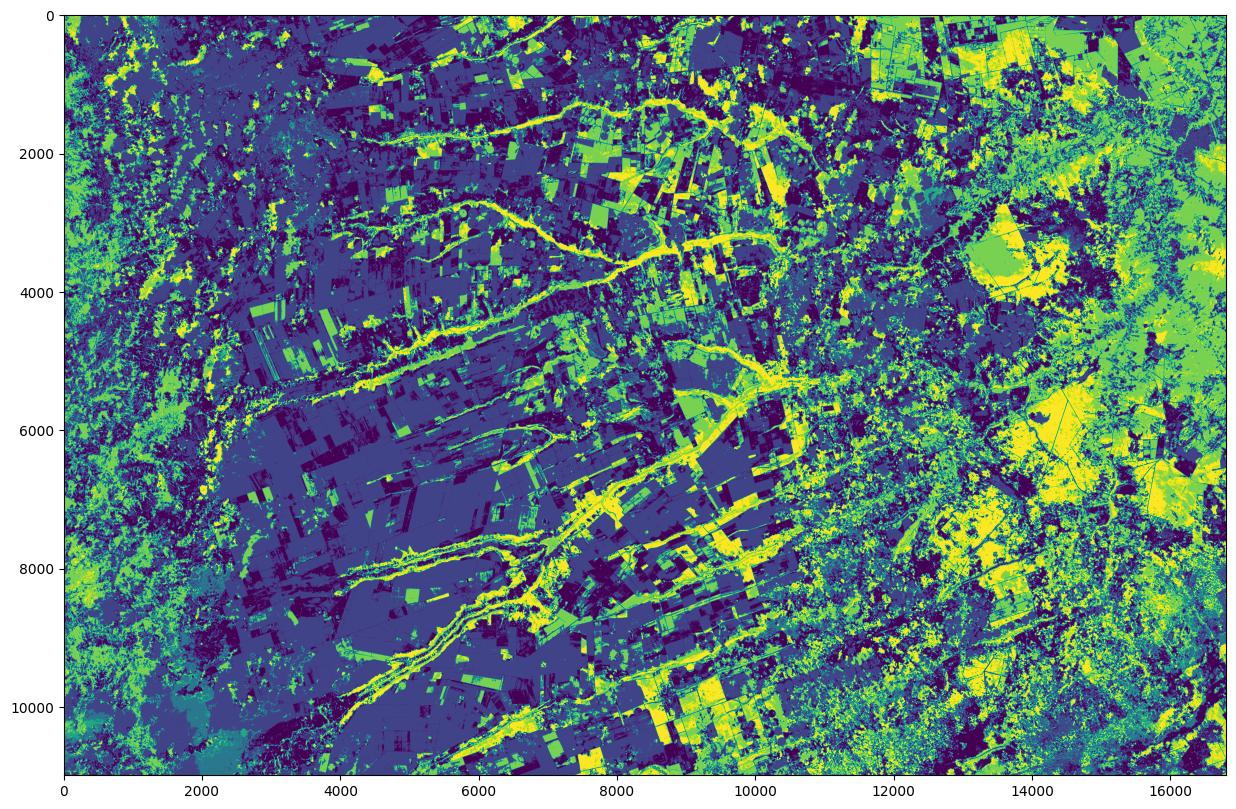